This example will build an exemplar sample set on a "bytes in" counter aggregator, which just sums up the number of bytes sent into our "application".
We will use these statistical exemplars to generate insights into the data that was aggregated away.

We'll start by importing everything we will need from opentelemetry to create the metrics:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

from collections import defaultdict

from opentelemetry import metrics
from opentelemetry.sdk.metrics import Counter, MeterProvider
from opentelemetry.sdk.metrics.export.aggregate import SumAggregator
from opentelemetry.sdk.metrics.export.controller import PushController
from opentelemetry.sdk.metrics.export.in_memory_metrics_exporter import InMemoryMetricsExporter
from opentelemetry.sdk.metrics.view import View, ViewConfig

We can then set up an in-memory metrics exporter so we can analyze the exemplar data in-service:

In [3]:
## set up opentelemetry

# Sets the global MeterProvider instance
metrics.set_meter_provider(MeterProvider())

meter = metrics.get_meter(__name__)

# Export to a python list so we can do stats with the data
exporter = InMemoryMetricsExporter()

# instead of waiting for the controller to tick over time, we will just tick it ourselves
controller = PushController(meter, exporter, 500)

We now need to create the bytes in metric, and assign it a view (this is where we set up exemplars):

In [4]:

# Create the metric that we will use
bytes_counter = meter.create_metric(
    name="bytes_counter",
    description="Number of bytes received by service",
    unit="By",
    value_type=int,
    metric_type=Counter,
)

# Every time interval we will collect 100 exemplars statistically (selected without bias)
aggregator_config = {"num_exemplars": 100, "statistical_exemplars": True}

# Assign a Sum aggregator to `bytes_counter` that collects exemplars
counter_view = View(
    bytes_counter,
    SumAggregator,
    aggregator_config=aggregator_config,
    label_keys=["environment"],
    view_config=ViewConfig.LABEL_KEYS,
)

meter.register_view(counter_view)

The last thing we need to do before we can start working with exemplars is generating a large set of data for metrics.
If the dataset is too small, we won't be able to collect a large enough subset of the input to analyze with exemplars.

If this was a real application, the data would be generated through requests to/from the server.

In [5]:
## generate the random metric data

def unknown_customer_calls():
    """Generate customer call data to our application"""

    # set a random seed for consistency of data for example purposes
    np.random.seed(1)
    # Make exemplar selection consistent for example purposes
    random.seed(1)

    # customer 123 is a big user, and made 1000 requests in this timeframe
    requests = np.random.normal(1000, 250, 1000) # 1000 requests with average 1000 bytes, covariance 100

    for request in requests:
        bytes_counter.add(int(request), {"environment": "production", "method": "REST", "customer_id": 123})

    # customer 247 is another big user, making fewer, but bigger requests
    requests = np.random.normal(5000, 1250, 200) # 200 requests with average size of 5k bytes

    for request in requests:
        bytes_counter.add(int(request), {"environment": "production", "method": "REST", "customer_id": 247})

    # There are many other smaller customers
    for customer_id in range(250):
        requests = np.random.normal(1000, 250, np.random.randint(1, 10))
        method = "REST" if np.random.randint(2) else "gRPC"
        for request in requests:
            bytes_counter.add(int(request), {"environment": "production", "method": method, "customer_id": customer_id})

unknown_customer_calls()

## Analyzing the Exemplars

Let's export our metric and collect the exemplars from the outputted aggregation:

In [6]:
# Tick the controller so it sends metrics to the exporter
controller.tick()

# collect metrics from our exporter
metric_data = exporter.get_exported_metrics()

# get the exemplars from the bytes_in counter aggregator
aggregator = metric_data[0].aggregator
exemplars = aggregator.checkpoint_exemplars

One of the key values of exemplars is its ability to handle dropped labels (labels that are too high cardinality to create a new metric record for each value). 
In our application, we drop the "customer_id" label since there is an unbounded number of possible labels. However, with exemplars, we can still estimate stats related
to the customer ids, for example the sizes of our top customers:

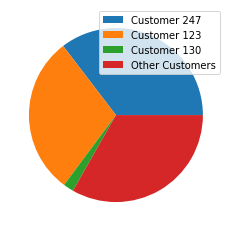

In [15]:
# Sum up the total bytes in per customer from all of the exemplars collected
customer_bytes_map = defaultdict(int)
for exemplar in exemplars:
    customer_bytes_map[exemplar.dropped_labels] += exemplar.value


customer_bytes_list = sorted(list(customer_bytes_map.items()), key=lambda t: t[1], reverse=True)

# Save our top 5 customers and sum all of the rest into "Others".
top_3_customers = [("Customer {}".format(dict(val[0])["customer_id"]), val[1]) for val in customer_bytes_list[:3]] + [("Other Customers", sum([val[1] for val in customer_bytes_list[3:]]))]

# unzip the data into X (sizes of each customer's contribution) and labels
labels, X = zip(*top_3_customers)

# create the chart with matplotlib and show it
plt.pie(X)
plt.legend(labels, loc = "upper right") 
plt.show()

Running this shows that the usage of our service is relatively closely split between customer 247, customer 123, and everyone else, which lines up closely with the data that was generated.
The more exemplars we sample, the more accurate this data will be, but also the more costly (in terms of memory usage) the metric would be.

We can use the "sample_count" property of exemplars to predict the actual number of bytes customers sent (vs the percentage)
For example, to predict the number of bytes customer 123 sent:

In [8]:
# Estimate how many bytes customer 123 sent
customer_123_bytes = customer_bytes_map[(("customer_id", 123), ("method", "REST"))]

# Since the exemplars were randomly sampled, all sample_counts will be the same
sample_count = exemplars[0].sample_count
full_customer_123_bytes = sample_count * customer_123_bytes

# With seed == 1 we get 1025206 - quite close to the statistical mean of 1000000! (more exemplars would make this estimation even more accurate)
print("Customer 123 sent about {} bytes this interval".format(int(full_customer_123_bytes)))


Customer 123 sent about 1025206 bytes this interval


We could also estimate the percentage of our top 25 customers that use gRPC (another dropped label):

In [10]:
# Determine the top 25 customers by how many bytes they sent in exemplars
top_25_customers = customer_bytes_list[:25]

# out of those 25 customers, determine how many used grpc, and come up with a ratio
percent_grpc = len(list(filter(lambda customer_value: customer_value[0][1][1] == "gRPC", top_25_customers))) / len(top_25_customers)

print("~{}% of the top 25 customers (by bytes in) used gRPC this interval".format(int(percent_grpc*100)))


~44% of the top 25 customers (by bytes in) used gRPC this interval


The value of exemplars goes beyond just handling dropped labels, however. We can also estimate the input distribution to the `bytes_counter` metric, through histograms or quantiles:


In [11]:
# Determine the 50th, 90th, and 99th percentile of byte size sent in
quantiles = np.quantile([exemplar.value for exemplar in exemplars], [0.5, 0.9, 0.99])
print("50th Percentile Bytes In:", int(quantiles[0]))
print("90th Percentile Bytes In:", int(quantiles[1]))
print("99th Percentile Bytes In:", int(quantiles[2]))

50th Percentile Bytes In: 1031
90th Percentile Bytes In: 1624
99th Percentile Bytes In: 6094


This is only a small subset of the things that can be done with exemplars - almost any statistic 
that could be created through an aggregator on the original data can be estimated through exemplars.